In [1]:
import gym
# import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt



In [22]:
from time import sleep
env = gym.make('LunarLander-v2', render_mode="human")  # continuous: LunarLanderContinuous-v2
env.reset()

for step in range(200):
	env.render()
	sleep(0.03)
	# take random action
	env.step(env.action_space.sample())

env.close()

c:\Users\adity\anaconda3\envs\rl-pathfinding\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [12]:
print("sample action:", env.action_space.sample())

sample action: 0


In [13]:
print("sample observation:", env.observation_space.sample())

sample observation: [ 0.70913225  0.6562002   2.4513288   2.1018486   1.594812   -3.6605492
  0.09252594  0.15245685]


In [16]:
grid_size = (10, 10)
start = (0, 0)
goal = (149, 349)
terrain = np.random.uniform(0, 5, grid_size)

In [7]:
print(np.shape(terrain))

(10, 10)


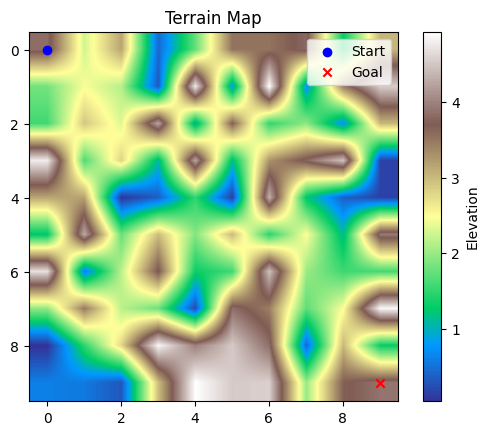

In [9]:
plt.imshow(terrain, cmap='terrain', interpolation='bilinear')
plt.colorbar(label='Elevation')
plt.scatter(start[1], start[0], color='blue', marker='o', label='Start')
plt.scatter(goal[1], goal[0], color='red', marker='x', label='Goal')
plt.legend()
plt.title('Terrain Map')
plt.show()

In [2]:
import rasterio
import plotly.graph_objects as go

# Path to the DEM file
# dem_path = 'D:\\adity\\Downloads\\b01_009894_1665_xi_13s042w_b02_010606_1666_xn_13s042w_tied-dem.tif'
# https://asc-pds-individual-investigations.s3.us-west-2.amazonaws.com/mars_mro_hirise_explorationzones_day_2023/index.html
dem_path = 'b18_016833_1714_xi_08s124w_g02_019035_1714_xn_08s124w_tied-dem.tif'



def replace_outliers_with_adjacent_average(arr, threshold):
    non_zero_values = arr[arr != 0]
    
    # Calculate mean and standard deviation of non-zero values
    mean_non_zero = np.mean(non_zero_values)
    std_non_zero = np.std(non_zero_values)
    
    # Identify values within one standard deviation of the mean
    within_std_values = non_zero_values[np.abs(non_zero_values - mean_non_zero) <= std_non_zero]
    
    # Calculate the mean of these values
    mean_within_std = np.mean(within_std_values)

    outliers = np.abs(arr - mean_within_std) > threshold * np.std(arr)  # Identify outliers using z-score
    print("OUTLIERS")
    print(outliers)

    
    
    # Iterate over each outlier
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if outliers[i, j]:
                adjacent_values = []
                # Collect adjacent values (horizontally and vertically)
                for di, dj in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                    if 0 <= i + di < arr.shape[0] and 0 <= j + dj < arr.shape[1]:
                        adjacent_values.append(arr[i + di, j + dj])
                # Replace outlier with the average of adjacent values
                # arr[i, j] = np.mean(arr[arr != 0])
                arr[i, j] = mean_within_std
    
    return arr

# Specify threshold for z-score (e.g., 2 for removing values > 2 standard deviations from mean)
threshold = 2

with rasterio.open(dem_path) as dataset:
    dem_data = dataset.read(1)  # Assuming the DEM data is in the first band
    transform = dataset.transform

# Print the shape of the DEM data
print("DEM data shape:", dem_data.shape)



height, width = dem_data.shape
x_indices, y_indices = np.meshgrid(np.arange(width), np.arange(height))
print(x_indices)
print(np.shape(x_indices))
# print(y_indices)

# # Apply the affine transformation to the grid indices
x_coords = transform[0] * x_indices + transform[1] * y_indices + transform[2]
y_coords = transform[3] * x_indices + transform[4] * y_indices + transform[5]


# # Print the first few values to verify
# print("Sample x_coords:\n", x_coords[:5, :5])
# print("Sample y_coords:\n", y_coords[:5, :5])


# # Normalize the coordinates
x_coords -= x_coords.min()
y_coords -= y_coords.min()

# # Scale the coordinates (if needed)
x_coords /= 18
y_coords /= 18




# (1445, 1905)

# row_start, row_end = 395, 745
# col_start, col_end = 700, 1050

# row_start, row_end = 700, 900
# col_start, col_end = 700, 900

# row_start, row_end = 600, 900
# col_start, col_end = 600, 900

row_start, row_end = 1200, 1355
col_start, col_end = 250, 600



# # Slice the data
dem_data_subset = dem_data[row_start:row_end, col_start:col_end]
x_coords_subset = x_coords[row_start:row_end, col_start:col_end]
y_coords_subset = y_coords[row_start:row_end, col_start:col_end]

dem_data_subset_normalized = (dem_data_subset - dem_data_subset.min()) / (dem_data_subset.max() - dem_data_subset.min())


# Replace outliers with the average of adjacent values
dem_data_subset_cleaned= replace_outliers_with_adjacent_average(dem_data_subset_normalized, threshold)

print("hii")
print(dem_data_subset_cleaned.max())
print(dem_data_subset_cleaned.min())


DEM data shape: (1445, 1905)
[[   0    1    2 ... 1902 1903 1904]
 [   0    1    2 ... 1902 1903 1904]
 [   0    1    2 ... 1902 1903 1904]
 ...
 [   0    1    2 ... 1902 1903 1904]
 [   0    1    2 ... 1902 1903 1904]
 [   0    1    2 ... 1902 1903 1904]]
(1445, 1905)
OUTLIERS
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
hii
1.0
0.99711096


In [3]:
print(np.shape(dem_data_subset_cleaned))

(155, 350)


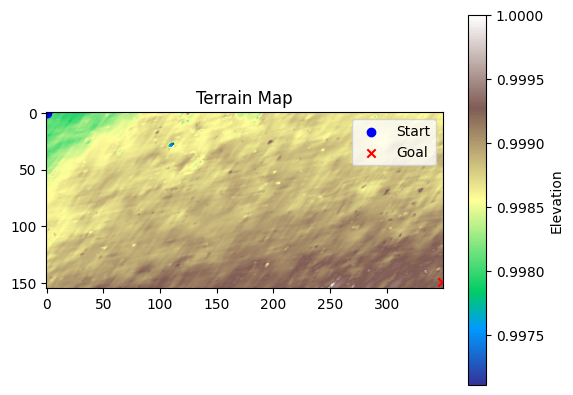

In [22]:
plt.imshow(dem_data_subset_cleaned, cmap='terrain', interpolation='bilinear')
plt.colorbar(label='Elevation')
plt.scatter(start[1], start[0], color='blue', marker='o', label='Start')
plt.scatter(goal[1], goal[0], color='red', marker='x', label='Goal')
plt.legend()
plt.title('Terrain Map')
plt.show()

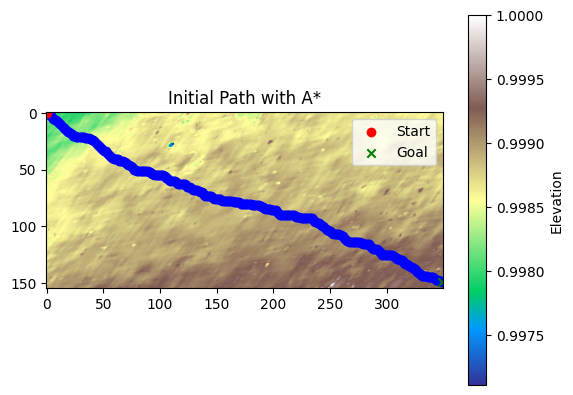

In [4]:
import numpy as np
import heapq
import matplotlib.pyplot as plt

# Define grid size and terrain
grid_size = dem_data_subset_cleaned.shape
terrain = dem_data_subset_cleaned
start = (0, 0)
goal = (149, 349)
kd = 1.0
kh = 2.0
kr = 1.0
lambda_ = 10.0

# Energy cost function
def calculate_energy_cost(x1, y1, x2, y2):
    d = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    h = terrain[x2, y2] - terrain[x1, y1]
    uphill_cost = kh * max(0, h)
    downhill_regeneration = kr * max(0, -h)
    return kd * d + uphill_cost - downhill_regeneration

# A* Algorithm
def astar(start, goal):
    def heuristic(a, b):
        return np.linalg.norm(np.array(a) - np.array(b))
    
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal)}
    
    while open_set:
        _, current = heapq.heappop(open_set)
        
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            return path[::-1]
        
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < grid_size[0] and 0 <= neighbor[1] < grid_size[1]:
                tentative_g_score = g_score[current] + calculate_energy_cost(current[0], current[1], neighbor[0], neighbor[1])
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
    
    return []

# Get initial path using A*
initial_path = astar(start, goal)

# Visualize initial path
plt.imshow(dem_data_subset_cleaned, cmap='terrain', interpolation='bilinear')
plt.colorbar(label='Elevation')
for point in initial_path:
    plt.scatter(point[1], point[0], color='blue', marker='o')
plt.scatter(start[1], start[0], color='red', marker='o', label='Start')
plt.scatter(goal[1], goal[0], color='green', marker='x', label='Goal')
plt.legend()
plt.title('Initial Path with A*')
plt.show()


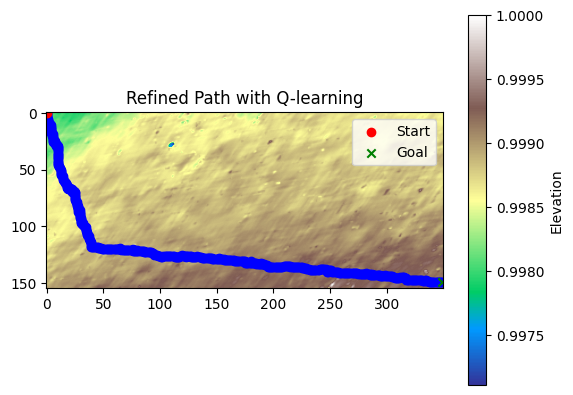

In [5]:
import random

# Define Q-learning parameters
alpha = 0.1
gamma = 0.9
epsilon = 0.1
num_episodes = 1000

# Initialize Q-table
Q = np.zeros((*grid_size, len([(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)])))

# Define actions
actions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

# Q-learning training
for episode in range(num_episodes):
    state = start
    previous_distance = np.linalg.norm(np.array(state) - np.array(goal))
    while state != goal:
        if random.uniform(0, 1) < epsilon:
            action = random.choice(range(len(actions)))
        else:
            action = np.argmax(Q[state[0], state[1], :])
        
        next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
        if 0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]:
            energy_cost = calculate_energy_cost(state[0], state[1], next_state[0], next_state[1])
            current_distance = np.linalg.norm(np.array(next_state) - np.array(goal))
            distance_reward = lambda_ * (previous_distance - current_distance)
            reward = -energy_cost + distance_reward
            previous_distance = current_distance
            
            Q[state[0], state[1], action] = (1 - alpha) * Q[state[0], state[1], action] + alpha * (reward + gamma * np.max(Q[next_state[0], next_state[1], :]))
            state = next_state

# Extract refined policy from Q-table
def extract_policy(Q):
    policy = {}
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            policy[(i, j)] = actions[np.argmax(Q[i, j, :])]
    return policy

policy = extract_policy(Q)

# Visualize refined path
def visualize_policy(policy, start, goal):
    state = start
    path = [state]
    while state != goal:
        action = policy[state]
        state = (state[0] + action[0], state[1] + action[1])
        path.append(state)
    return path

refined_path = visualize_policy(policy, start, goal)

plt.imshow(terrain, cmap='terrain', interpolation='bilinear')
plt.colorbar(label='Elevation')
for point in refined_path:
    plt.scatter(point[1], point[0], color='blue', marker='o')
plt.scatter(start[1], start[0], color='red', marker='o', label='Start')
plt.scatter(goal[1], goal[0], color='green', marker='x', label='Goal')
plt.legend()
plt.title('Refined Path with Q-learning')
plt.show()


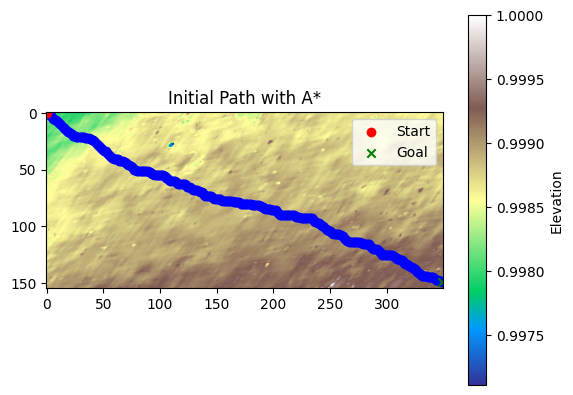

Initial Path Energy Cost: 409.30828452690383


In [6]:
import numpy as np
import heapq
import matplotlib.pyplot as plt

# Define grid size and terrain
grid_size = dem_data_subset_cleaned.shape
terrain = dem_data_subset_cleaned
start = (0, 0)
goal = (149, 349)
kd = 1.0
kh = 2.0
kr = 1.0
lambda_ = 10.0

# Energy cost function
def calculate_energy_cost(x1, y1, x2, y2):
    d = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    h = terrain[x2, y2] - terrain[x1, y1]
    uphill_cost = kh * max(0, h)
    downhill_regeneration = kr * max(0, -h)
    return kd * d + uphill_cost - downhill_regeneration

# A* Algorithm
def astar(start, goal):
    def heuristic(a, b):
        return np.linalg.norm(np.array(a) - np.array(b))
    
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal)}
    total_energy_cost = 0
    
    while open_set:
        _, current = heapq.heappop(open_set)
        
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path = path[::-1]
            for i in range(len(path) - 1):
                total_energy_cost += calculate_energy_cost(path[i][0], path[i][1], path[i+1][0], path[i+1][1])
            return path, total_energy_cost
        
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < grid_size[0] and 0 <= neighbor[1] < grid_size[1]:
                tentative_g_score = g_score[current] + calculate_energy_cost(current[0], current[1], neighbor[0], neighbor[1])
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
    
    return [], 0

# Get initial path and energy cost using A*
initial_path, initial_energy_cost = astar(start, goal)

# Visualize initial path
plt.imshow(terrain, cmap='terrain', interpolation='bilinear')
plt.colorbar(label='Elevation')
for point in initial_path:
    plt.scatter(point[1], point[0], color='blue', marker='o')
plt.scatter(start[1], start[0], color='red', marker='o', label='Start')
plt.scatter(goal[1], goal[0], color='green', marker='x', label='Goal')
plt.legend()
plt.title('Initial Path with A*')
plt.show()

print(f"Initial Path Energy Cost: {initial_energy_cost}")


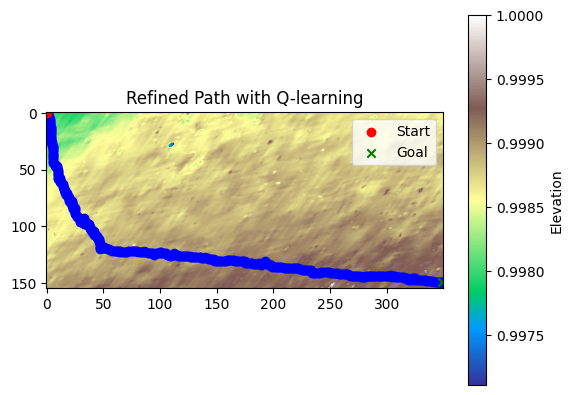

Refined Path Energy Cost: 526.9036436836036


In [7]:
import random

# Define Q-learning parameters
alpha = 0.1
gamma = 0.9
epsilon = 0.1
num_episodes = 1000

# Initialize Q-table
Q = np.zeros((*grid_size, len([(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)])))

# Define actions
actions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

# Q-learning training
for episode in range(num_episodes):
    state = start
    previous_distance = np.linalg.norm(np.array(state) - np.array(goal))
    while state != goal:
        if random.uniform(0, 1) < epsilon:
            action = random.choice(range(len(actions)))
        else:
            action = np.argmax(Q[state[0], state[1], :])
        
        next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
        if 0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]:
            energy_cost = calculate_energy_cost(state[0], state[1], next_state[0], next_state[1])
            current_distance = np.linalg.norm(np.array(next_state) - np.array(goal))
            distance_reward = lambda_ * (previous_distance - current_distance)
            reward = -energy_cost + distance_reward
            previous_distance = current_distance
            
            Q[state[0], state[1], action] = (1 - alpha) * Q[state[0], state[1], action] + alpha * (reward + gamma * np.max(Q[next_state[0], next_state[1], :]))
            state = next_state

# Extract refined policy from Q-table
def extract_policy(Q):
    policy = {}
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            policy[(i, j)] = actions[np.argmax(Q[i, j, :])]
    return policy

policy = extract_policy(Q)

# Visualize refined path and calculate energy cost
def visualize_policy(policy, start, goal):
    state = start
    path = [state]
    total_energy_cost = 0
    while state != goal:
        action = policy[state]
        next_state = (state[0] + action[0], state[1] + action[1])
        total_energy_cost += calculate_energy_cost(state[0], state[1], next_state[0], next_state[1])
        state = next_state
        path.append(state)
    return path, total_energy_cost

refined_path, refined_energy_cost = visualize_policy(policy, start, goal)

plt.imshow(terrain, cmap='terrain', interpolation='bilinear')
plt.colorbar(label='Elevation')
for point in refined_path:
    plt.scatter(point[1], point[0], color='blue', marker='o')
plt.scatter(start[1], start[0], color='red', marker='o', label='Start')
plt.scatter(goal[1], goal[0], color='green', marker='x', label='Goal')
plt.legend()
plt.title('Refined Path with Q-learning')
plt.show()

print(f"Refined Path Energy Cost: {refined_energy_cost}")


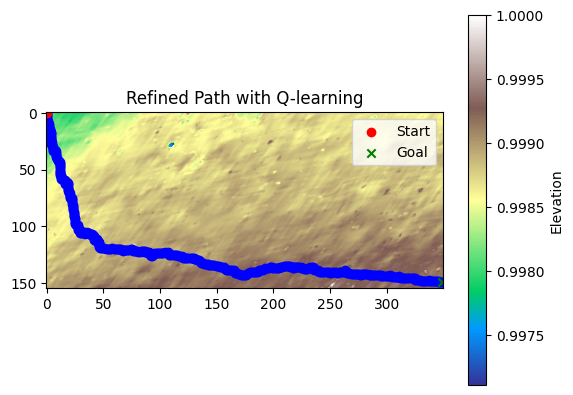

Initial Path Energy Cost: 409.30828452690383
Refined Path Energy Cost: 529.6307395649803


In [8]:
import random

epsilon = 0.1  # Starting exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995  # Decay rate for exploration probability

num_episodes = 5000  # Increase number of episodes


# Initialize Q-table
Q = np.zeros((*grid_size, len(actions)))

for episode in range(num_episodes):
    state = start
    previous_distance = np.linalg.norm(np.array(state) - np.array(goal))
    while state != goal:
        if random.uniform(0, 1) < epsilon:
            action = random.choice(range(len(actions)))
        else:
            action = np.argmax(Q[state[0], state[1], :])

        next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
        if 0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]:
            energy_cost = calculate_energy_cost(state[0], state[1], next_state[0], next_state[1])
            current_distance = np.linalg.norm(np.array(next_state) - np.array(goal))
            distance_reward = lambda_ * (previous_distance - current_distance)
            reward = -energy_cost + distance_reward
            previous_distance = current_distance

            Q[state[0], state[1], action] = (1 - alpha) * Q[state[0], state[1], action] + alpha * (reward + gamma * np.max(Q[next_state[0], next_state[1], :]))
            state = next_state

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

def extract_policy(Q):
    policy = {}
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            policy[(i, j)] = actions[np.argmax(Q[i, j, :])]
    return policy

policy = extract_policy(Q)

def visualize_policy(policy, start, goal):
    state = start
    path = [state]
    total_energy_cost = 0
    while state != goal:
        action = policy[state]
        next_state = (state[0] + action[0], state[1] + action[1])
        total_energy_cost += calculate_energy_cost(state[0], state[1], next_state[0], next_state[1])
        state = next_state
        path.append(state)
    return path, total_energy_cost

refined_path, refined_energy_cost = visualize_policy(policy, start, goal)

plt.imshow(terrain, cmap='terrain', interpolation='bilinear')
plt.colorbar(label='Elevation')
for point in refined_path:
    plt.scatter(point[1], point[0], color='blue', marker='o')
plt.scatter(start[1], start[0], color='red', marker='o', label='Start')
plt.scatter(goal[1], goal[0], color='green', marker='x', label='Goal')
plt.legend()
plt.title('Refined Path with Q-learning')
plt.show()

print(f"Initial Path Energy Cost: {initial_energy_cost}")
print(f"Refined Path Energy Cost: {refined_energy_cost}")


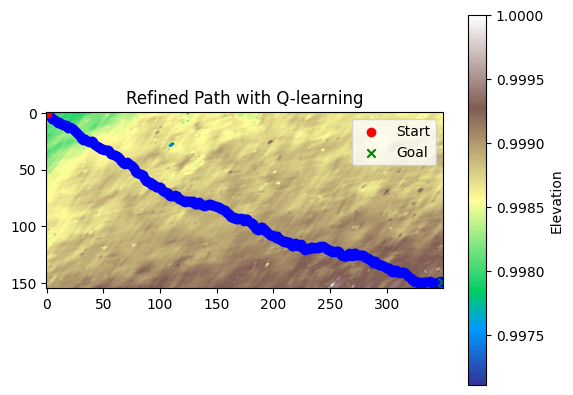

Initial Path Energy Cost (A*): 409.30828452690383
Refined Path Energy Cost (Q-learning): 461.2792382773454


In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Define the grid size and terrain
grid_size = dem_data_subset_cleaned.shape
terrain = dem_data_subset_cleaned
start = (0, 0)
goal = (149, 349)
kd = 1.0
kh = 2.0
kr = 0.5  # Reduced regeneration factor for realistic effect
lambda_ = 10.0  # Weight for distance reward

# Actions (8 possible moves including diagonals)
actions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

# Energy cost function
def calculate_energy_cost(x1, y1, x2, y2):
    d = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    h = terrain[x2, y2] - terrain[x1, y1]
    if h > 0:
        return kd * d + kh * h  # Uphill movement cost
    else:
        return kd * d - kr * abs(h)  # Downhill movement cost (with energy regeneration)

# Q-learning parameters
alpha = 0.05
gamma = 0.95
epsilon = 0.9
epsilon_min = 0.1
epsilon_decay = 0.995
num_episodes = 10000

# Initialize Q-table
Q = np.zeros((*grid_size, len(actions)))

# Q-learning training
for episode in range(num_episodes):
    state = start
    previous_distance = np.linalg.norm(np.array(state) - np.array(goal))
    while state != goal:
        if random.uniform(0, 1) < epsilon:
            action = random.choice(range(len(actions)))
        else:
            action = np.argmax(Q[state[0], state[1], :])

        next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
        if 0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]:
            energy_cost = calculate_energy_cost(state[0], state[1], next_state[0], next_state[1])
            current_distance = np.linalg.norm(np.array(next_state) - np.array(goal))
            distance_reward = lambda_ * (previous_distance - current_distance)
            if next_state == goal:
                reward = 100  # Large reward for reaching the goal
            else:
                reward = -energy_cost + distance_reward
            previous_distance = current_distance

            Q[state[0], state[1], action] = (1 - alpha) * Q[state[0], state[1], action] + alpha * (reward + gamma * np.max(Q[next_state[0], next_state[1], :]))
            state = next_state

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# Extract policy from Q-table
def extract_policy(Q):
    policy = {}
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            policy[(i, j)] = actions[np.argmax(Q[i, j, :])]
    return policy

policy = extract_policy(Q)

# Visualize refined path and calculate energy cost
def visualize_policy(policy, start, goal):
    state = start
    path = [state]
    total_energy_cost = 0
    while state != goal:
        action = policy[state]
        next_state = (state[0] + action[0], state[1] + action[1])
        total_energy_cost += calculate_energy_cost(state[0], state[1], next_state[0], next_state[1])
        state = next_state
        path.append(state)
    return path, total_energy_cost

# Get initial A* path and energy cost
# You need to define the initial_path and initial_energy_cost for A* path

refined_path, refined_energy_cost = visualize_policy(policy, start, goal)

plt.imshow(terrain, cmap='terrain', interpolation='bilinear')
plt.colorbar(label='Elevation')
for point in refined_path:
    plt.scatter(point[1], point[0], color='blue', marker='o')
plt.scatter(start[1], start[0], color='red', marker='o', label='Start')
plt.scatter(goal[1], goal[0], color='green', marker='x', label='Goal')
plt.legend()
plt.title('Refined Path with Q-learning')
plt.show()

print(f"Initial Path Energy Cost (A*): {initial_energy_cost}")
print(f"Refined Path Energy Cost (Q-learning): {refined_energy_cost}")


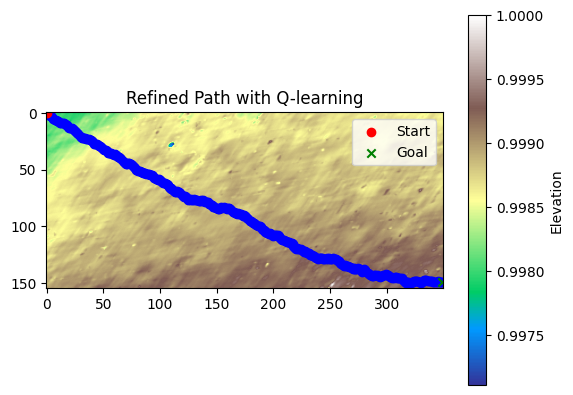

Initial Path Energy Cost (A*): 409.30828452690383
Refined Path Energy Cost (Q-learning): 448.2075914659606


In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Define the grid size and terrain
grid_size = dem_data_subset_cleaned.shape
terrain = dem_data_subset_cleaned
start = (0, 0)
goal = (149, 349)
kd = 1.0
kh = 2.0
kr = 0.5  # Reduced regeneration factor for realistic effect
lambda_ = 10.0  # Weight for distance reward

# Actions (8 possible moves including diagonals)
actions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

# Energy cost function
def calculate_energy_cost(x1, y1, x2, y2):
    d = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    h = terrain[x2, y2] - terrain[x1, y1]
    if h > 0:
        return kd * d + kh * h  # Uphill movement cost
    else:
        return kd * d - kr * abs(h)  # Downhill movement cost (with energy regeneration)

# Q-learning parameters
alpha = 0.05
gamma = 0.95
epsilon = 0.9
epsilon_min = 0.1
epsilon_decay = 0.995
num_episodes = 25000

# Initialize Q-table
Q = np.zeros((*grid_size, len(actions)))

# Q-learning training
for episode in range(num_episodes):
    state = start
    previous_distance = np.linalg.norm(np.array(state) - np.array(goal))
    while state != goal:
        if random.uniform(0, 1) < epsilon:
            action = random.choice(range(len(actions)))
        else:
            action = np.argmax(Q[state[0], state[1], :])

        next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
        if 0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]:
            energy_cost = calculate_energy_cost(state[0], state[1], next_state[0], next_state[1])
            current_distance = np.linalg.norm(np.array(next_state) - np.array(goal))
            distance_reward = lambda_ * (previous_distance - current_distance)
            if next_state == goal:
                reward = 100  # Large reward for reaching the goal
            else:
                reward = -energy_cost + distance_reward
            previous_distance = current_distance

            Q[state[0], state[1], action] = (1 - alpha) * Q[state[0], state[1], action] + alpha * (reward + gamma * np.max(Q[next_state[0], next_state[1], :]))
            state = next_state

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# Extract policy from Q-table
def extract_policy(Q):
    policy = {}
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            policy[(i, j)] = actions[np.argmax(Q[i, j, :])]
    return policy

policy = extract_policy(Q)

# Visualize refined path and calculate energy cost
def visualize_policy(policy, start, goal):
    state = start
    path = [state]
    total_energy_cost = 0
    while state != goal:
        action = policy[state]
        next_state = (state[0] + action[0], state[1] + action[1])
        total_energy_cost += calculate_energy_cost(state[0], state[1], next_state[0], next_state[1])
        state = next_state
        path.append(state)
    return path, total_energy_cost

# Get initial A* path and energy cost
# You need to define the initial_path and initial_energy_cost for A* path

refined_path, refined_energy_cost = visualize_policy(policy, start, goal)

plt.imshow(terrain, cmap='terrain', interpolation='bilinear')
plt.colorbar(label='Elevation')
for point in refined_path:
    plt.scatter(point[1], point[0], color='blue', marker='o')
plt.scatter(start[1], start[0], color='red', marker='o', label='Start')
plt.scatter(goal[1], goal[0], color='green', marker='x', label='Goal')
plt.legend()
plt.title('Refined Path with Q-learning')
plt.show()

print(f"Initial Path Energy Cost (A*): {initial_energy_cost}")
print(f"Refined Path Energy Cost (Q-learning): {refined_energy_cost}")


In [ ]:
num_episodes = 75000

# Initialize Q-table
Q = np.zeros((*grid_size, len(actions)))

# Q-learning training
for episode in range(num_episodes):
    state = start
    previous_distance = np.linalg.norm(np.array(state) - np.array(goal))
    while state != goal:
        if random.uniform(0, 1) < epsilon:
            action = random.choice(range(len(actions)))
        else:
            action = np.argmax(Q[state[0], state[1], :])

        next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
        if 0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]:
            energy_cost = calculate_energy_cost(state[0], state[1], next_state[0], next_state[1])
            current_distance = np.linalg.norm(np.array(next_state) - np.array(goal))
            distance_reward = lambda_ * (previous_distance - current_distance)
            if next_state == goal:
                reward = 100  # Large reward for reaching the goal
            else:
                reward = -energy_cost + distance_reward
            previous_distance = current_distance

            Q[state[0], state[1], action] = (1 - alpha) * Q[state[0], state[1], action] + alpha * (reward + gamma * np.max(Q[next_state[0], next_state[1], :]))
            state = next_state

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# Extract policy from Q-table
def extract_policy(Q):
    policy = {}
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            policy[(i, j)] = actions[np.argmax(Q[i, j, :])]
    return policy

policy = extract_policy(Q)

# Visualize refined path and calculate energy cost
def visualize_policy(policy, start, goal):
    state = start
    path = [state]
    total_energy_cost = 0
    while state != goal:
        action = policy[state]
        next_state = (state[0] + action[0], state[1] + action[1])
        total_energy_cost += calculate_energy_cost(state[0], state[1], next_state[0], next_state[1])
        state = next_state
        path.append(state)
    return path, total_energy_cost

# Get initial A* path and energy cost
# You need to define the initial_path and initial_energy_cost for A* path

refined_path, refined_energy_cost = visualize_policy(policy, start, goal)

plt.imshow(terrain, cmap='terrain', interpolation='bilinear')
plt.colorbar(label='Elevation')
for point in refined_path:
    plt.scatter(point[1], point[0], color='blue', marker='o')
plt.scatter(start[1], start[0], color='red', marker='o', label='Start')
plt.scatter(goal[1], goal[0], color='green', marker='x', label='Goal')
plt.legend()
plt.title('Refined Path with Q-learning')
plt.show()

print(f"Initial Path Energy Cost (A*): {initial_energy_cost}")
print(f"Refined Path Energy Cost (Q-learning): {refined_energy_cost}")
